In [1]:
%load_ext autoreload
%autoreload 2

### Graph embedding notebook

Evaluate options for graph embeddings

some useful references:

- https://distill.pub/2021/gnn-intro/
- https://web.stanford.edu/class/cs224w/
- https://pytorch-geometric.readthedocs.io/en/latest/

Structure of the nb:

1) data prep
2) model and training
3) visualization

Next steps:

Train/test split, include Argoverse data

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from enum import Enum

import pickle
import networkx as nx
from torch_geometric.nn import GINEConv, global_mean_pool, global_max_pool, global_add_pool

import torch
import torch.nn.functional as F
import os
import glob
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import glob
import pickle
from tqdm import tqdm
from graph_creator.plot_graphs import plot_lane_map_advanced, add_actors_to_map, add_actor_edges_to_map
from graph_creator.MapGraph import MapGraph
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

from graph_creator.graph_embeddings import GraphDataset, TrainableGraphGINE, contrastive_loss, augment_graph, get_feature_dimensions, networkx_to_pyg

### Data prep

In [3]:
graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/*.pkl")
graph_paths = [path for path in graph_paths if "2025-09-05" in path]
print(len(graph_paths))


4442


In [4]:
# add argoverse data
argoverse_graph_paths = glob.glob("/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/*.pkl")
graph_paths.extend(argoverse_graph_paths)
print(len(graph_paths))


8030


In [5]:
# Load data
graph_ds = GraphDataset(graph_paths)
train_loader = DataLoader(graph_ds, batch_size=32, shuffle=True)

/home/tmuehlen/.cache/pypoetry/virtualenvs/graph-creator-_1ofKhL9-py3.10/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# set([path.split("/")[-1].split("_")[1] for path in graph_paths])

In [ ]:
# try out data loader
graph_ds.__getitem__(4300)

#batch = next(iter(train_loader))

torch_geometric.data.data.Data

### Training

In [8]:
# Model setup
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
node_dim, edge_dim = get_feature_dimensions()
model = TrainableGraphGINE(node_dim, edge_dim, 256, 96, 4).to(device)



In [9]:
# get the pre-training loss
total_loss = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch[0].to(device)
        aug_batch = augment_graph(batch).to(device)
        outputs1 = model(batch)
        outputs2 = model(aug_batch)
        loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
        total_loss += loss.item()

# if epoch % 1 == 0:
print(f'pre-training loss:: {total_loss/len(train_loader):.4f}')

pre-training loss:: 2.4582


In [10]:
# Training
# hm, too lazy to do a proper learning rate schedule
for i in range(7):
    lr = 0.02*0.75**i
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"loop {i}, Learning rate: {lr}")
    for epoch in range(15):
        total_loss = 0
    
        for batch in train_loader:
            batch = batch[0].to(device)
            aug_batch = augment_graph(batch).to(device)

            optimizer.zero_grad()

            outputs1 = model(batch)
            outputs2 = model(aug_batch)

            loss = contrastive_loss(outputs1['projection'], outputs2['projection'])
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if epoch % 1 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')



Learning rate: 0.02
Epoch 0, Loss: 0.8296
Epoch 1, Loss: 0.4863
Epoch 2, Loss: 0.4117
Epoch 3, Loss: 0.3658
Epoch 4, Loss: 0.3336
Epoch 5, Loss: 0.3228
Epoch 6, Loss: 0.2948
Epoch 7, Loss: 0.2898
Epoch 8, Loss: 0.2695
Epoch 9, Loss: 0.2747
Epoch 10, Loss: 0.2601
Epoch 11, Loss: 0.2522
Epoch 12, Loss: 0.2823
Epoch 13, Loss: 0.2597
Epoch 14, Loss: 0.2483
Learning rate: 0.015
Epoch 0, Loss: 0.2417
Epoch 1, Loss: 0.2254
Epoch 2, Loss: 0.2253
Epoch 3, Loss: 0.2026
Epoch 4, Loss: 0.1963
Epoch 5, Loss: 0.1845
Epoch 6, Loss: 0.1828
Epoch 7, Loss: 0.1812
Epoch 8, Loss: 0.1665
Epoch 9, Loss: 0.1621
Epoch 10, Loss: 0.1600
Epoch 11, Loss: 0.1492
Epoch 12, Loss: 0.1525
Epoch 13, Loss: 0.1501
Epoch 14, Loss: 0.1441
Learning rate: 0.01125
Epoch 0, Loss: 0.1414
Epoch 1, Loss: 0.1299
Epoch 2, Loss: 0.1343
Epoch 3, Loss: 0.1258
Epoch 4, Loss: 0.1230
Epoch 5, Loss: 0.1281
Epoch 6, Loss: 0.1220
Epoch 7, Loss: 0.1275
Epoch 8, Loss: 0.1196
Epoch 9, Loss: 0.1162
Epoch 10, Loss: 0.1158
Epoch 11, Loss: 0.1188


### Inference

In [11]:
# Inference loop
model.eval()
all_embeddings = []
all_paths = []

with torch.no_grad():
   for batch in tqdm(train_loader):  # or test_loader
       all_paths.extend(batch[1]) 
       batch = batch[0].to(device)
       outputs = model(batch)
       embeddings = outputs['embeddings']
       all_embeddings.append(embeddings.cpu())

# Concatenate all embeddings
final_embeddings = torch.cat(all_embeddings, dim=0)
print(f'Extracted {final_embeddings.shape[0]} embeddings of dimension {final_embeddings.shape[1]}')

100%|██████████| 251/251 [00:03<00:00, 69.75it/s]

Extracted 8030 embeddings of dimension 256


In [12]:
graph_dates = [path.split("/")[-1].split("_")[1] for path in all_paths]
#all_paths


In [13]:
graph_type = [path.split("/")[6] for path in all_paths]

### Visualization of embeddings

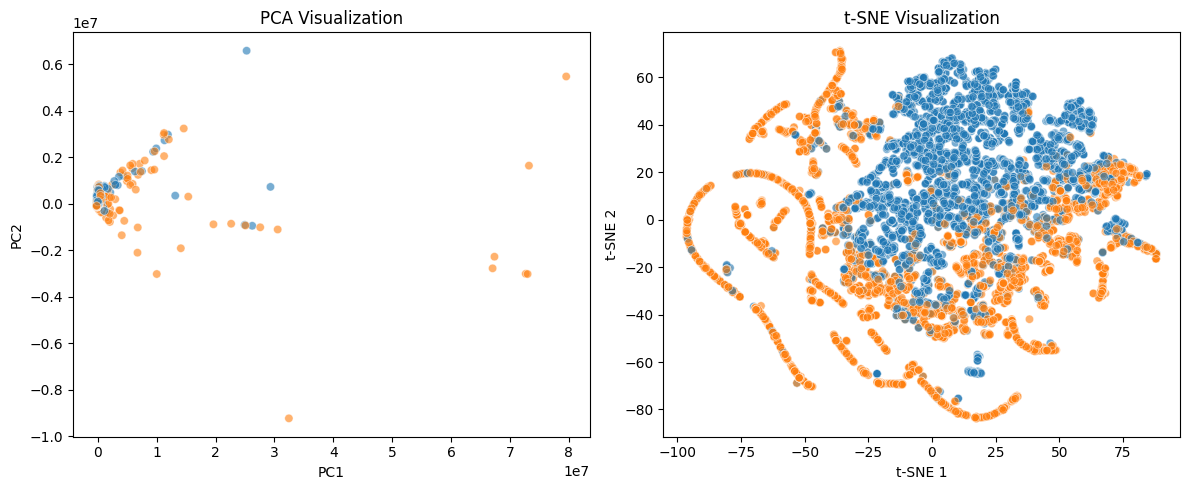

In [14]:

# Convert embeddings to numpy
embeddings_np = final_embeddings.numpy()

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_np)

pca_df = pd.DataFrame(pca_result)
pca_df.columns = ["pca1", "pca2"]
pca_df["graph_type"] = graph_type
pca_df["graph_path"] = all_paths
pca_df.head()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x="pca1", y="pca2", alpha=0.6, hue="graph_type", legend = False, data=pca_df)
#plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.6)
plt.title('PCA Visualization')
plt.xlabel('PC1')
plt.ylabel('PC2')

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(embeddings_np)
tsne_df = pd.DataFrame(tsne_result)
tsne_df.columns = ["tsne1", "tsne2"]
tsne_df["graph_type"] = graph_type
tsne_df["graph_path"] = all_paths

plt.subplot(1, 2, 2)
# plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)
sns.scatterplot(x="tsne1", y="tsne2", alpha=0.6, hue="graph_type", legend = False, data=tsne_df)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

In [15]:
os.getcwd()
os.chdir("../..")
os.getcwd()

'/home/tmuehlen/repos/graph_coverage'

In [16]:
pca_emb_df = pd.concat([pca_df, pd.DataFrame(embeddings_np)], axis = 1)
pca_emb_df.head(2)

pca1           pca2    graph_type  \
0 -140462.09375  -40259.460938  argoverse_nx   
1 -216073.68750 -106642.734375         carla   

                                          graph_path             0  \
0  /home/tmuehlen/repos/graph_coverage/actor_grap... -10203.081055   
1  /home/tmuehlen/repos/graph_coverage/actor_grap...  -5998.328613   

             1            2            3             4            5  ...  \
0  -109.251335  1714.008545 -5330.668457 -18930.175781 -2322.414551  ...   
1 -2677.676514  -488.575653  -755.005371  -1926.581055   492.019775  ...   

           246          247          248          249          250  \
0  6371.679688  6767.041992 -4431.714355  -186.294861  3875.425293   
1  1417.984741 -2432.912354 -1399.345215  1304.800171    46.730427   

           251         252          253          254           255  
0  2192.380127 -421.835449 -1662.558350  4841.083008  13715.191406  
1  2174.565430 -586.028320 -2012.473022  -122.693840   1453.840332  

[2 rows x 260 columns]

In [17]:
mask_carla = pca_df.graph_type == "carla"
mask_argo = pca_df.graph_type == "argoverse_nx"
pca_carla_df = pca_df[mask_carla].reset_index(drop=True)
pca_argo_df = pca_df[mask_argo].reset_index(drop=True)


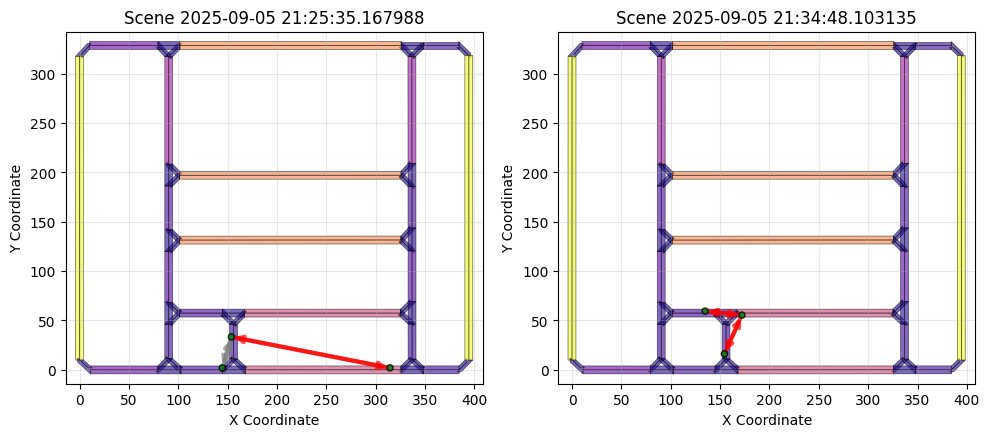

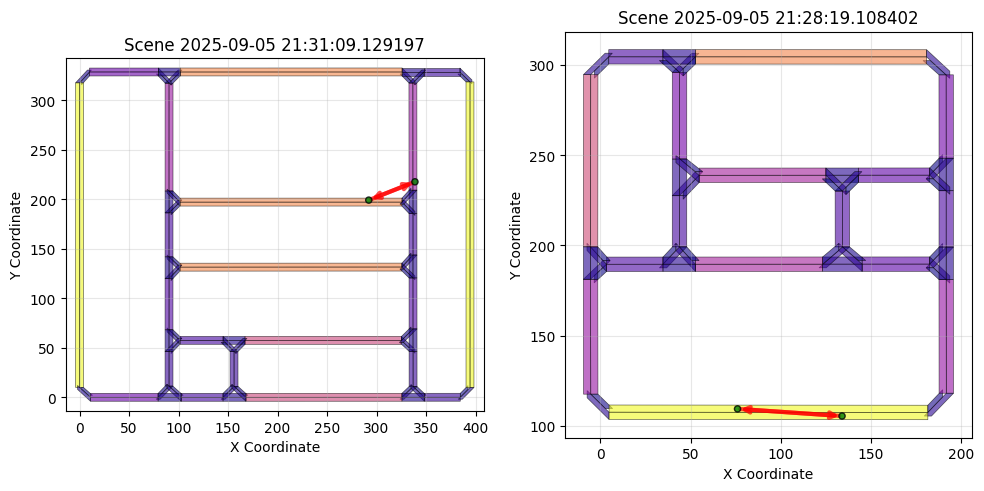

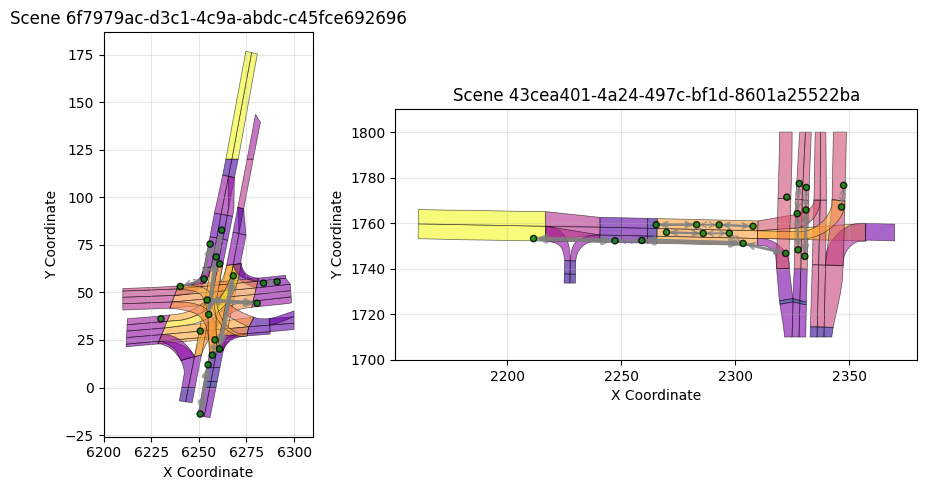

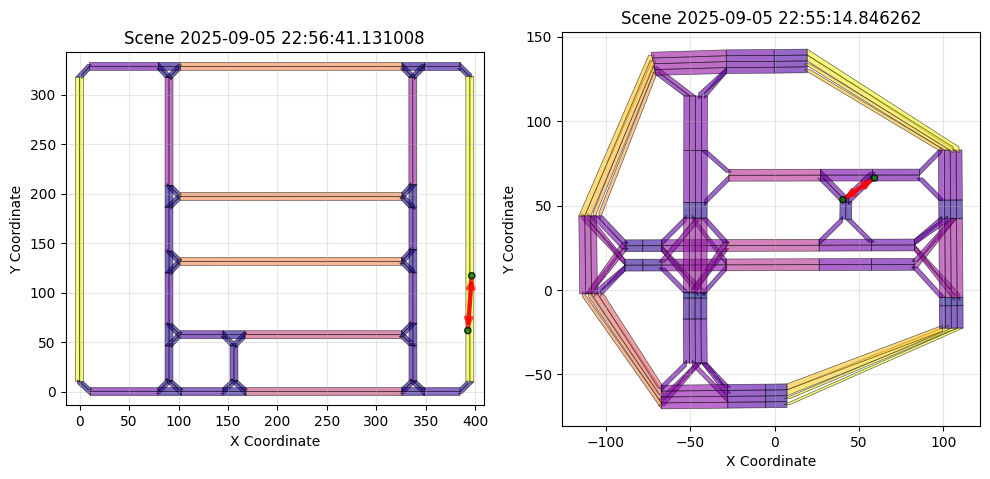

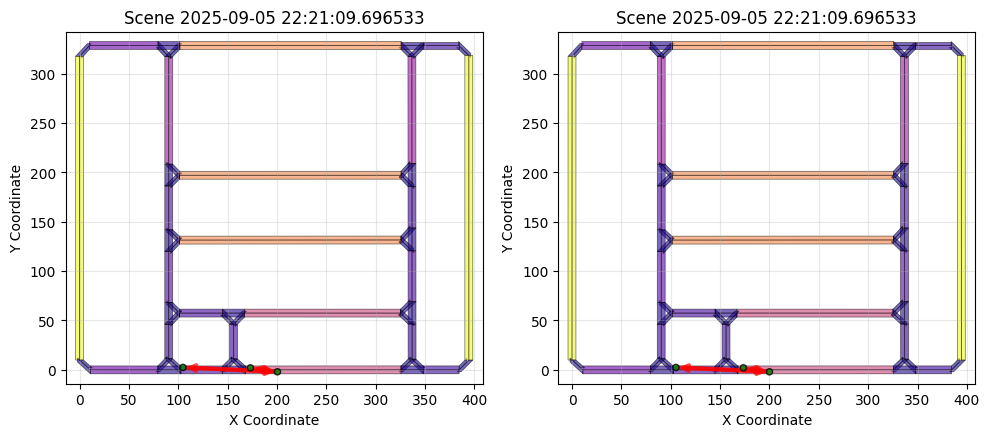

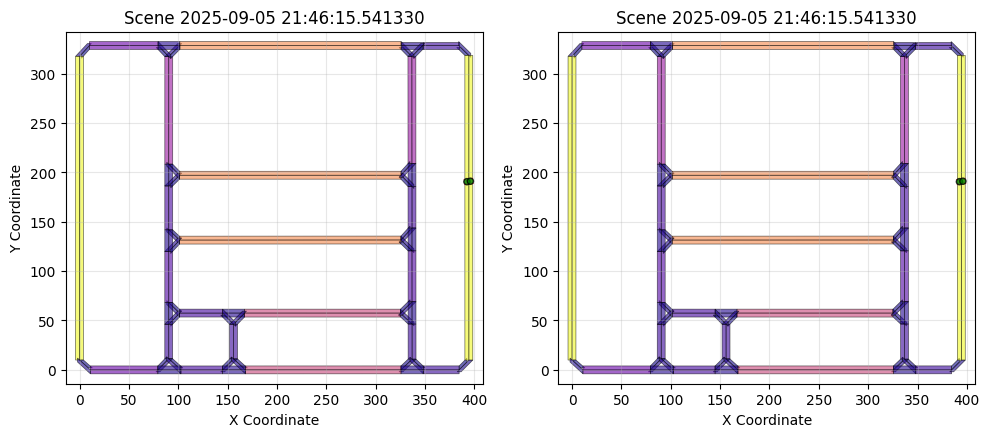

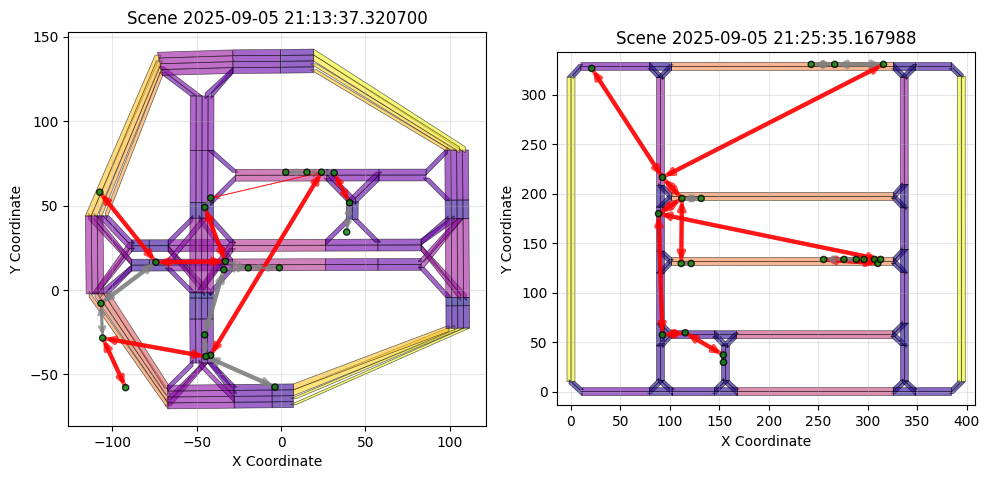

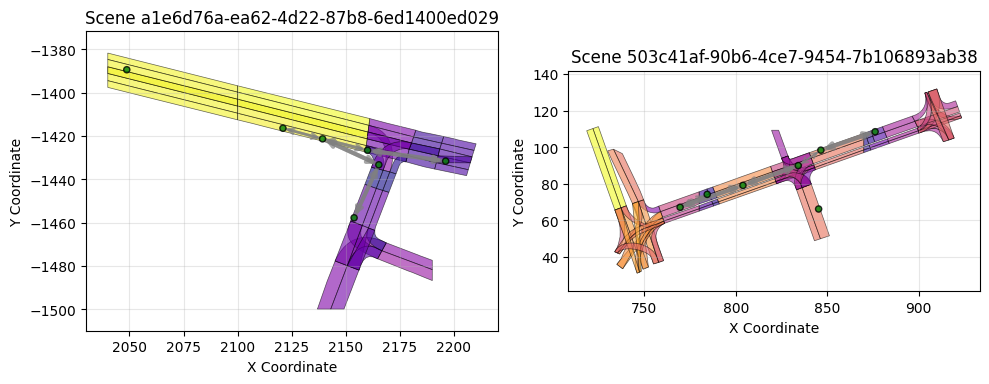

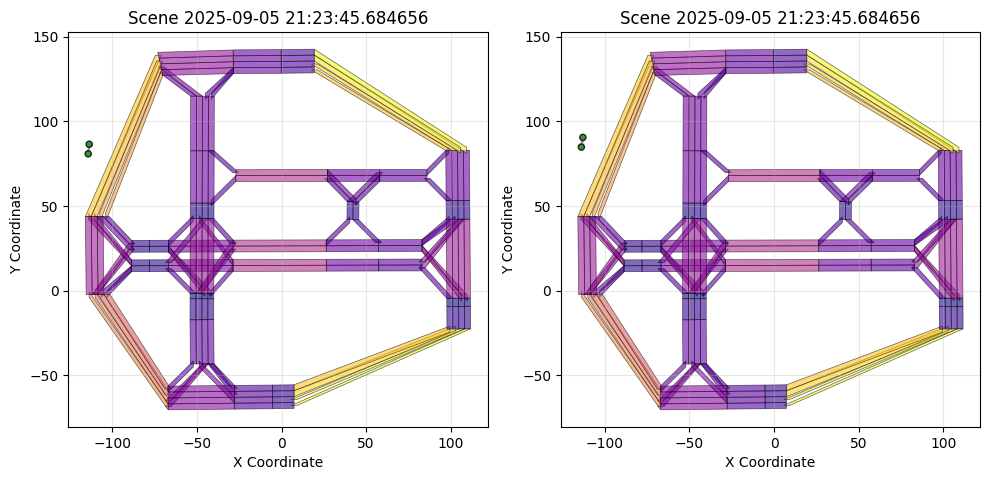

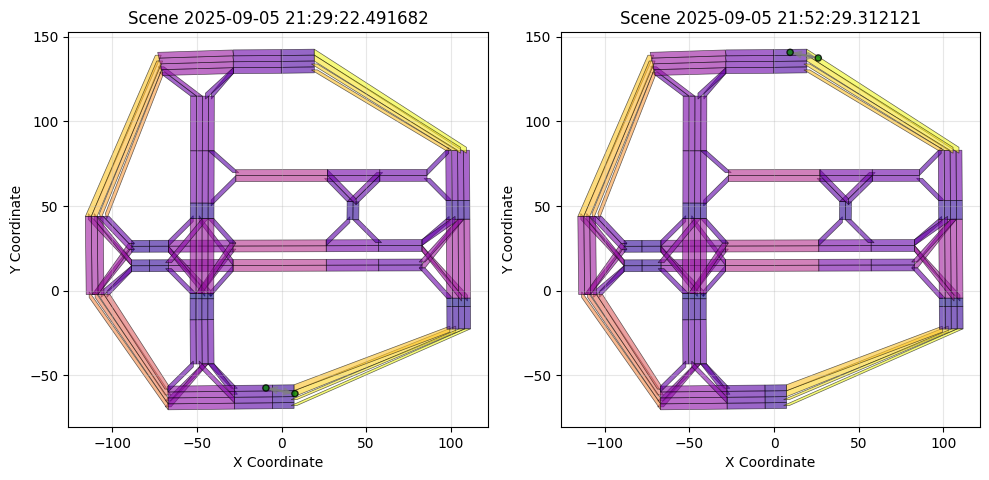

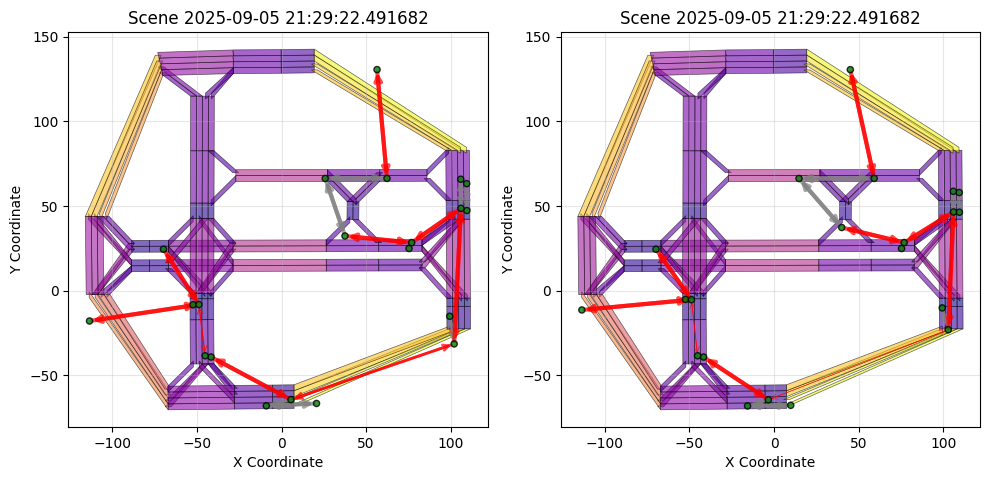

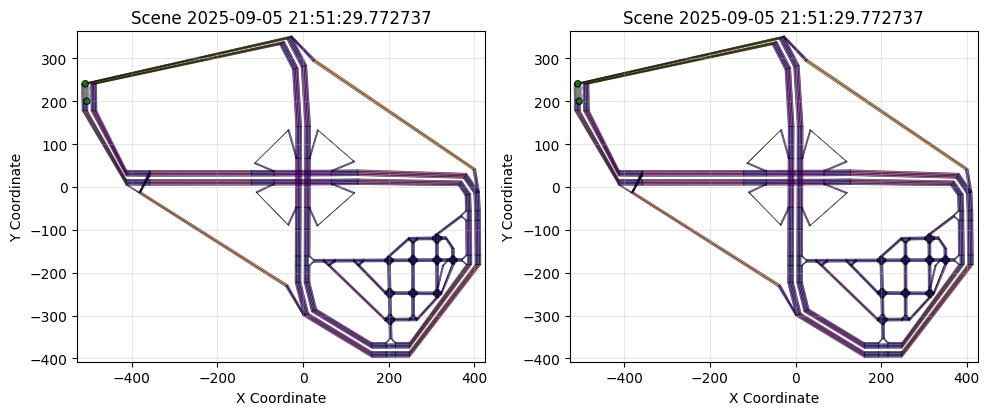

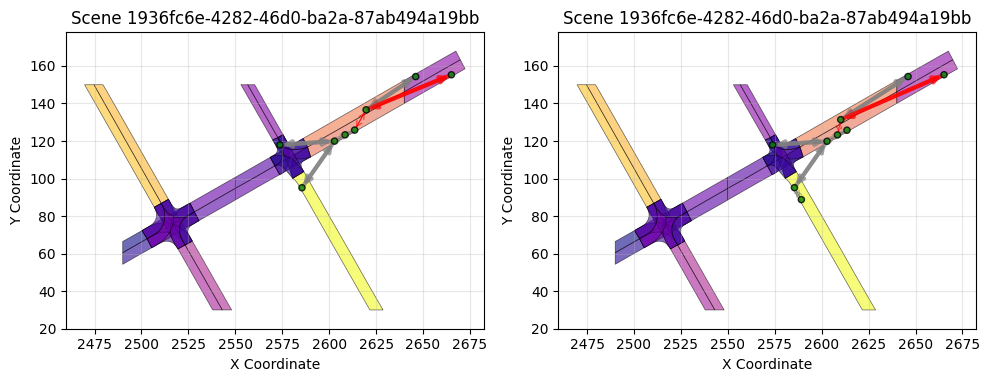

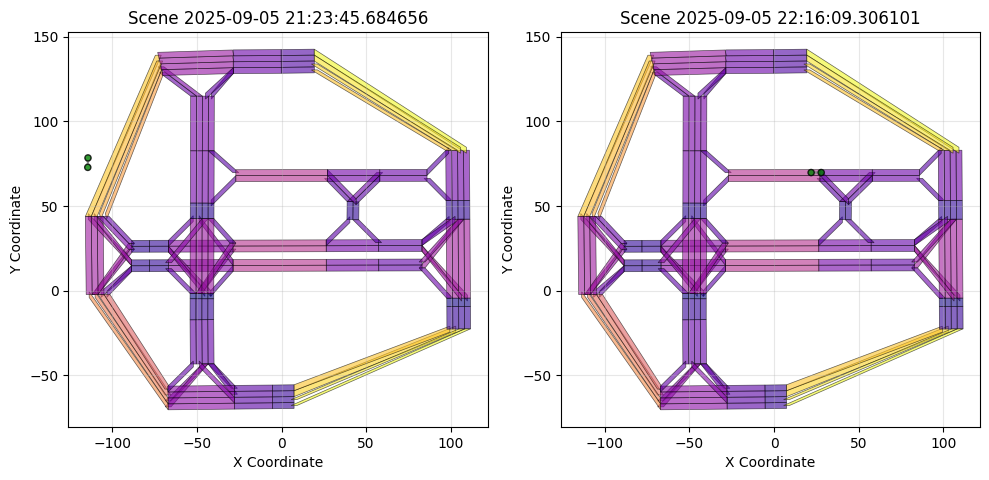

Error processing scene 2025-09-05 23:17:21.132074 and 2025-09-05 23:19:31.667341: 'node_info'


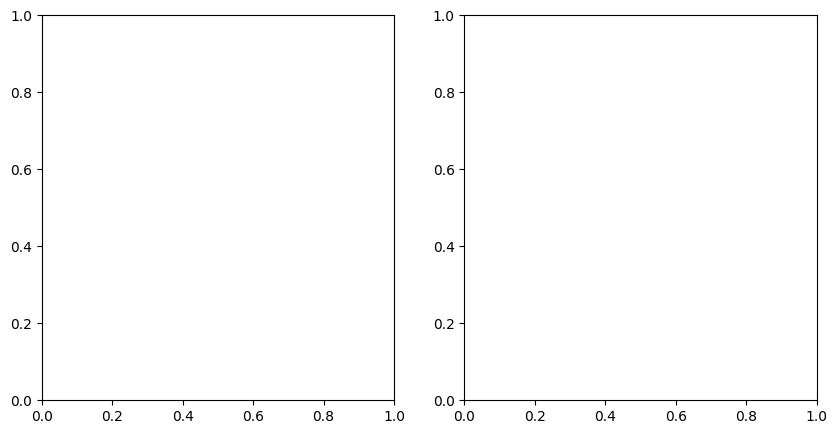

In [18]:
# comparing, no restrictions
for i in range(15):
    try:
        first = pca_emb_df.sample(1)
        pca_emb_df["sq_diff"] = ((pca_emb_df[list(range(256))] - first[list(range(256))].values)**2).sum(axis = 1)

        #pca_emb_df["dist"] = (pca_em.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_emb_df.sort_values("sq_diff", inplace=True)

        if first.graph_type.iloc[0] == "carla":
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:26]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
            g_map_1 = g_map_1.graph
        else:
            # argoverse option
            graph_1 = pca_emb_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_1 = graph_1[:36]
            file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
            with open(file_path_1, 'rb') as f:
                nx_graph_1 = pickle.load(f)
            g_map_1 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_1.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
            g_map_1 = g_map_1.graph.graph

        if pca_emb_df.graph_type.iloc[1] == "carla":
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:26]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
            g_map_2 = g_map_2.graph
        else:
            # argoverse option
            graph_2 = pca_emb_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
            scn_2 = graph_2[:36]
            file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
            with open(file_path_2, 'rb') as f:
                nx_graph_2 = pickle.load(f)
            g_map_2 = MapGraph()
            # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
            g_map_2.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
            g_map_2 = g_map_2.graph.graph



        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        # # First scene (left subplot)
        fig, ax1 = plot_lane_map_advanced(g_map_1, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # # Second scene (right subplot)
        fig, ax2 = plot_lane_map_advanced(g_map_2, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


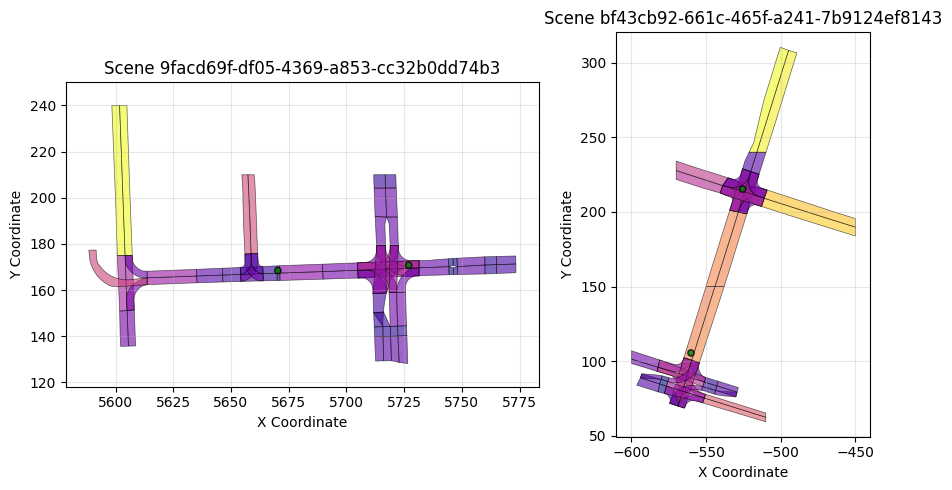

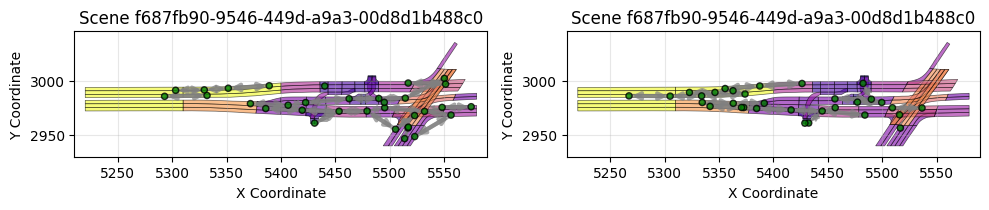

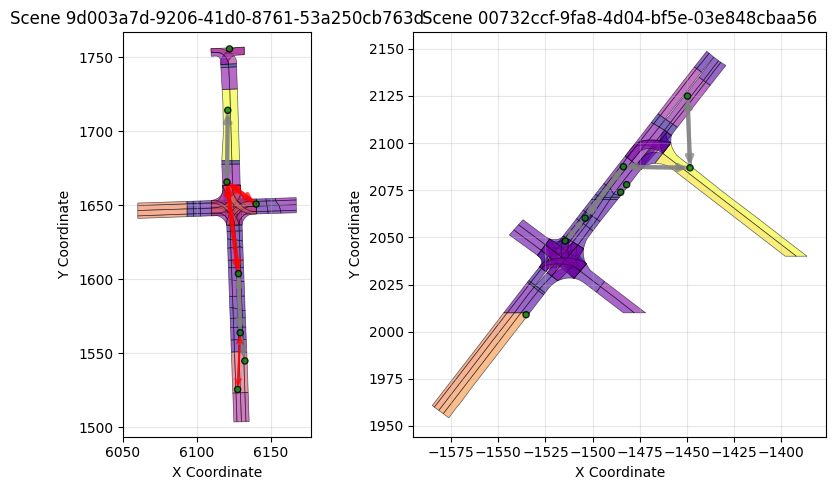

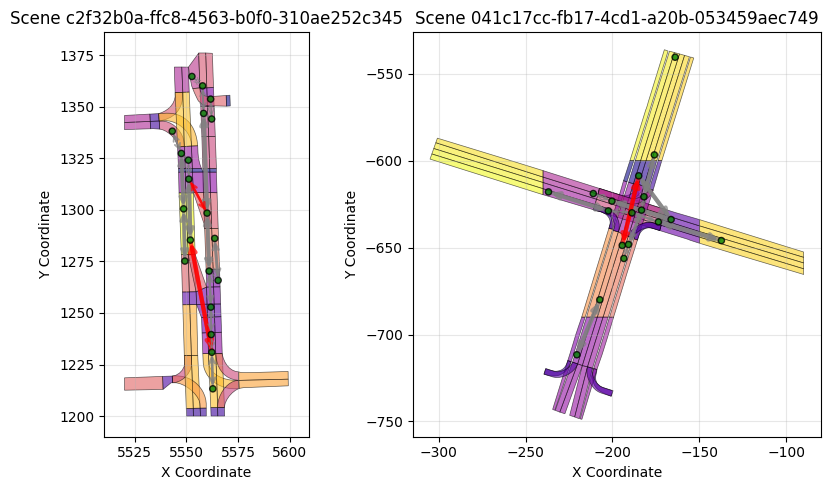

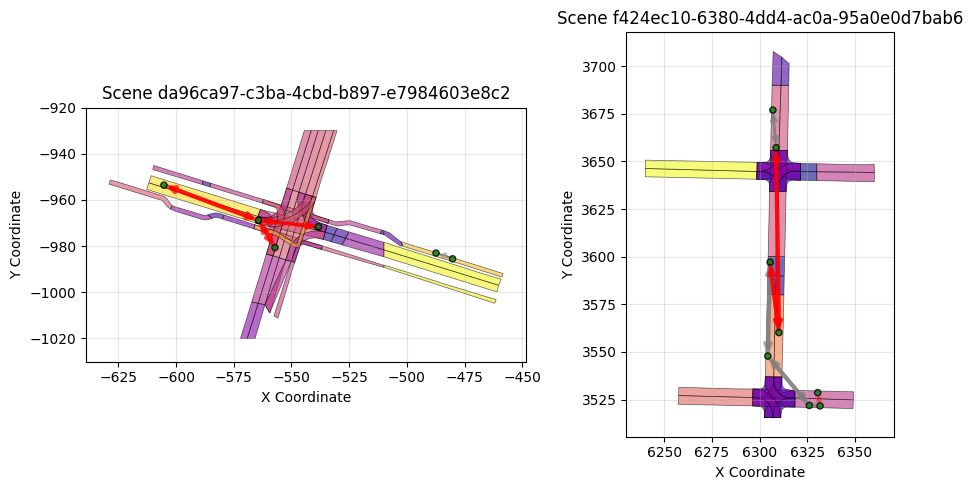

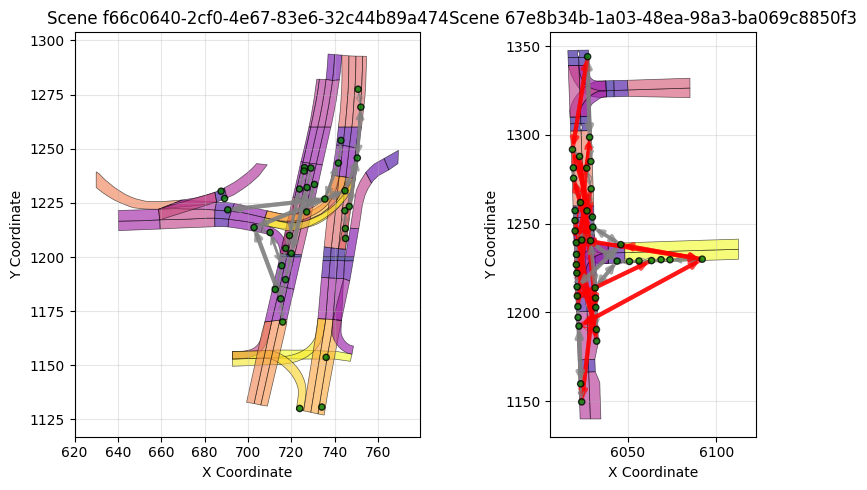

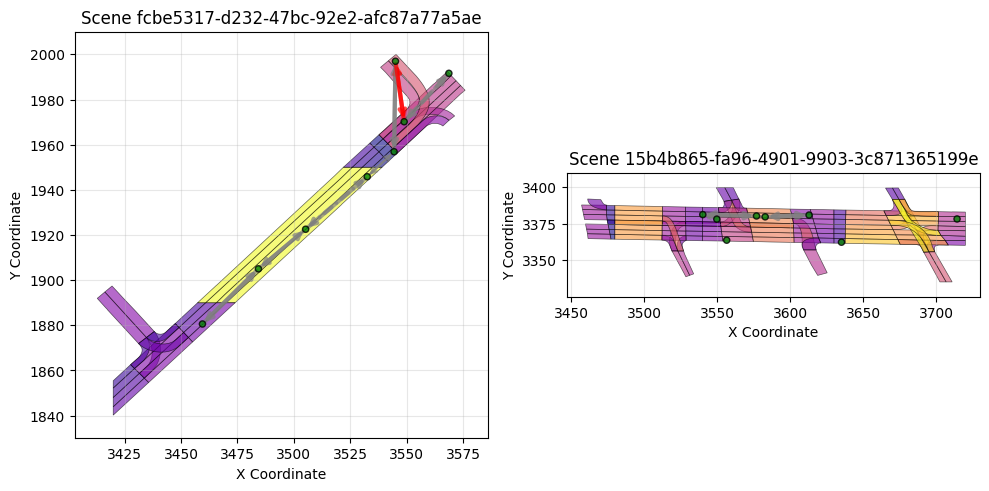

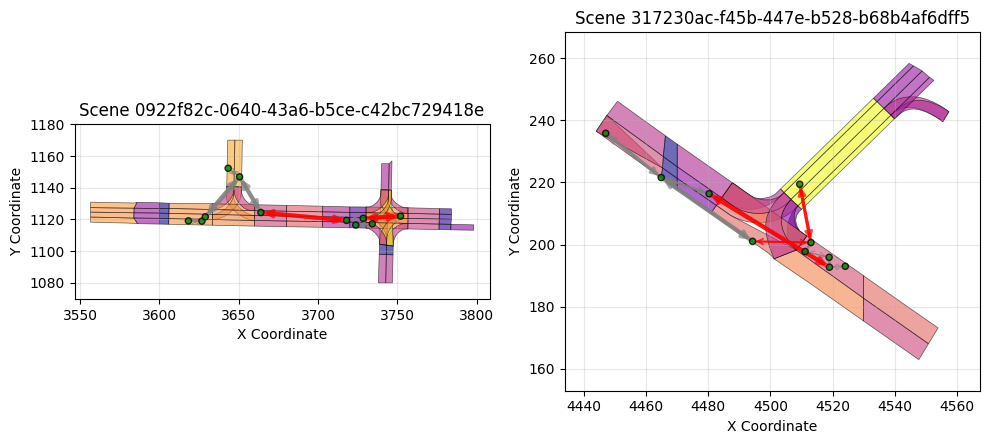

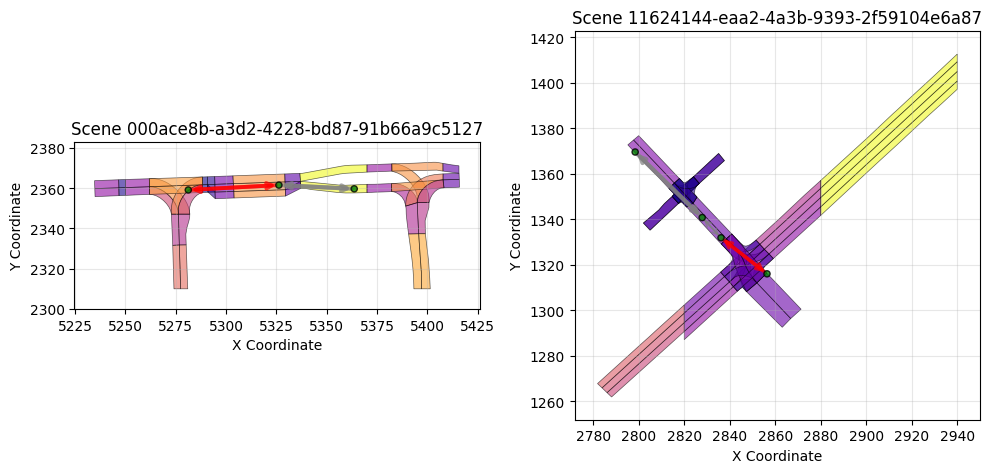

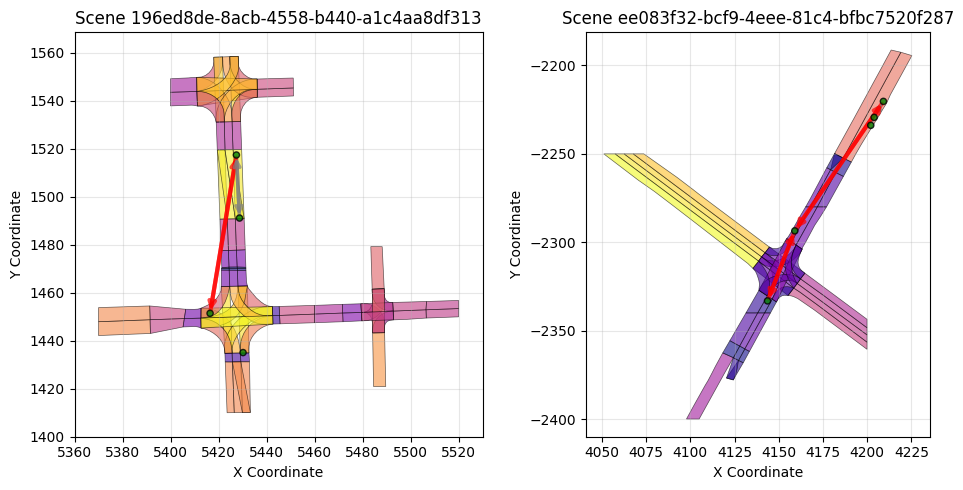

In [19]:
# comparing argo to argo
for i in range(10):
    try:
        first = pca_argo_df.sample(1)
        pca_argo_df["dist"] = (pca_argo_df.pca1 - first.pca1.iloc[0])**2 + (pca_argo_df.pca2 - first.pca2.iloc[0])**2 
        pca_argo_df.sort_values("dist", inplace=True)
        graph_1 = pca_argo_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_argo_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:36]
        scn_2 = graph_2[:36]
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/argoverse_nx/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        # "/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/000ace8b-a3d2-4228-bd87-91b66a9c5127_map_graph.pkl"
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_1}_map_graph.pkl')
        fig, ax1 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/data/argoversion_actor_and_map/{scn_2}_map_graph.pkl')
        fig, ax2 = plot_lane_map_advanced(g_map.graph.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


2025-09-05 22:12:37.118738_14_0 2025-09-05 22:12:37.118738
2025-09-05 21:35:27.112436_5_0 2025-09-05 21:35:27.112436


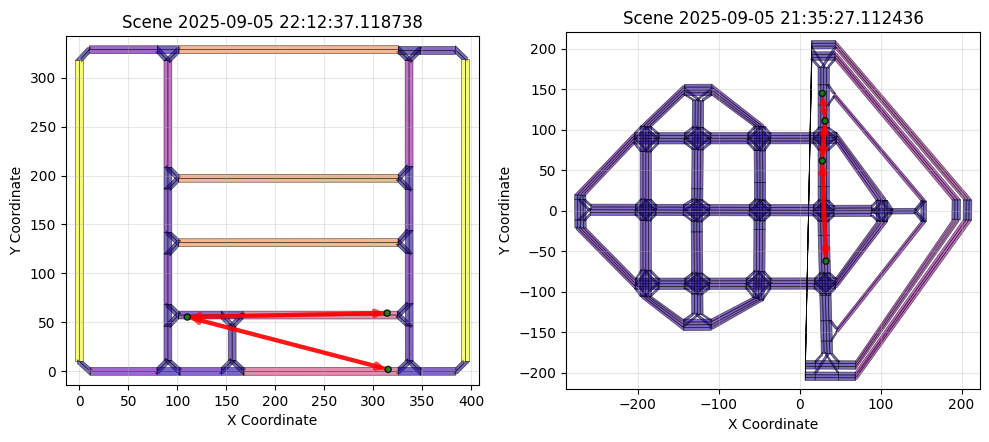

2025-09-05 21:37:24.776396_7_1 2025-09-05 21:37:24.776396
2025-09-05 21:37:24.776396_8_0 2025-09-05 21:37:24.776396


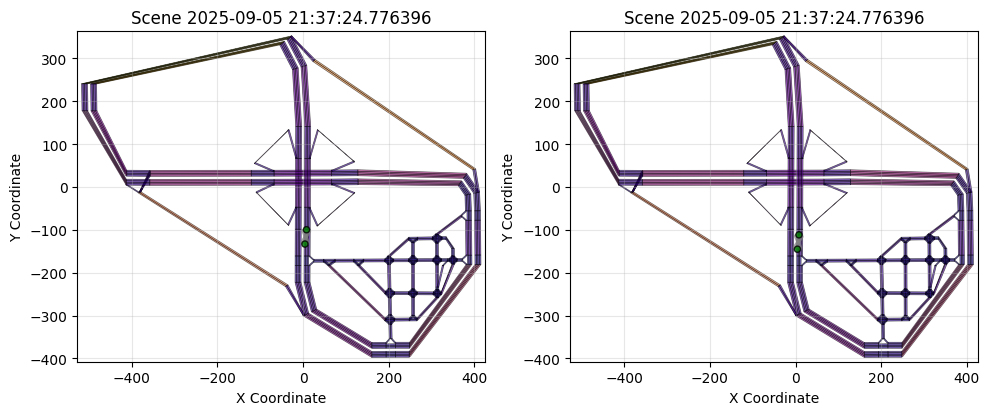

2025-09-05 21:13:37.320700_3_2 2025-09-05 21:13:37.320700
2025-09-05 21:40:03.642113_11_1 2025-09-05 21:40:03.642113


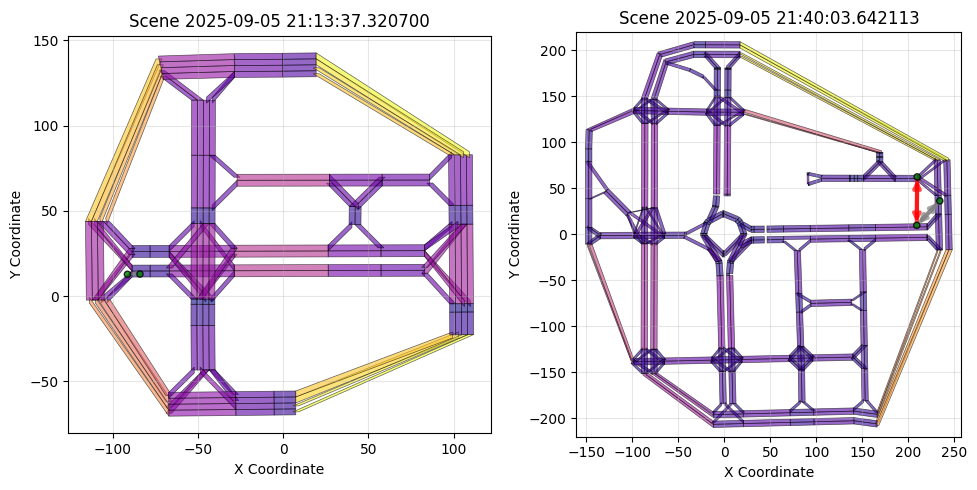

2025-09-05 21:51:11.551432_0_1 2025-09-05 21:51:11.551432
2025-09-05 21:36:07.600472_10_3 2025-09-05 21:36:07.600472


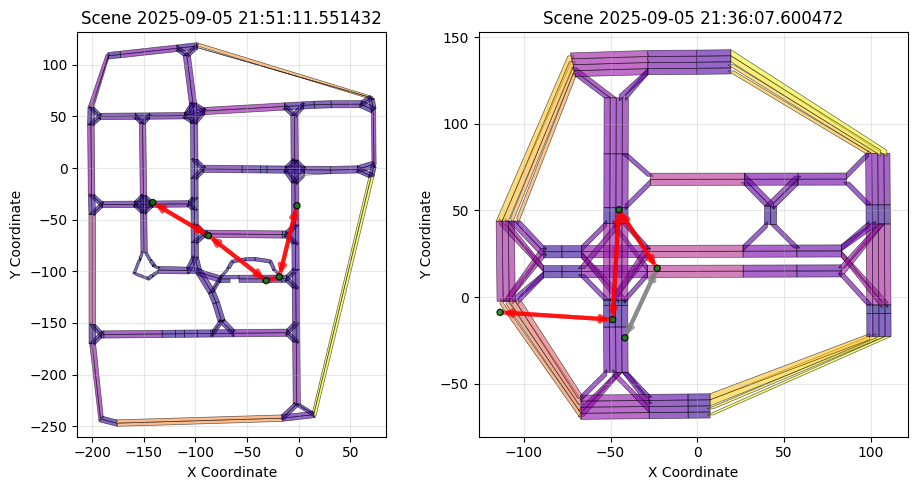

2025-09-05 21:41:34.315588_14_1 2025-09-05 21:41:34.315588
2025-09-05 21:41:34.315588_13_1 2025-09-05 21:41:34.315588


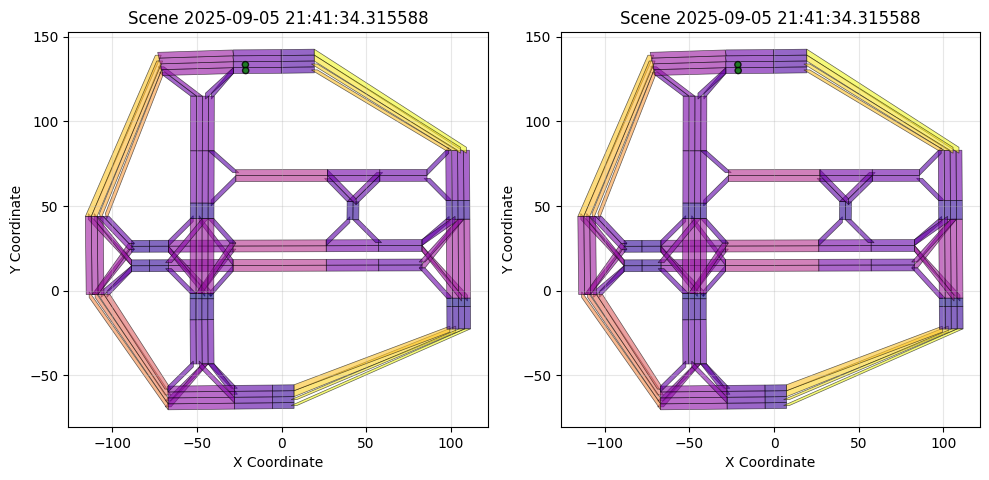

2025-09-05 22:21:09.696533_0_0 2025-09-05 22:21:09.696533
2025-09-05 22:58:11.600340_1_1 2025-09-05 22:58:11.600340


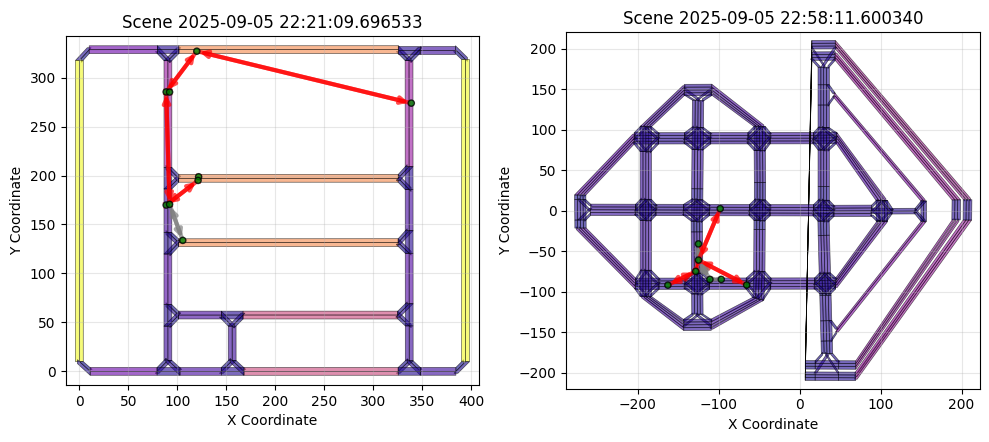

2025-09-05 22:24:00.124751_3_1 2025-09-05 22:24:00.124751
2025-09-05 21:26:57.714374_15_0 2025-09-05 21:26:57.714374


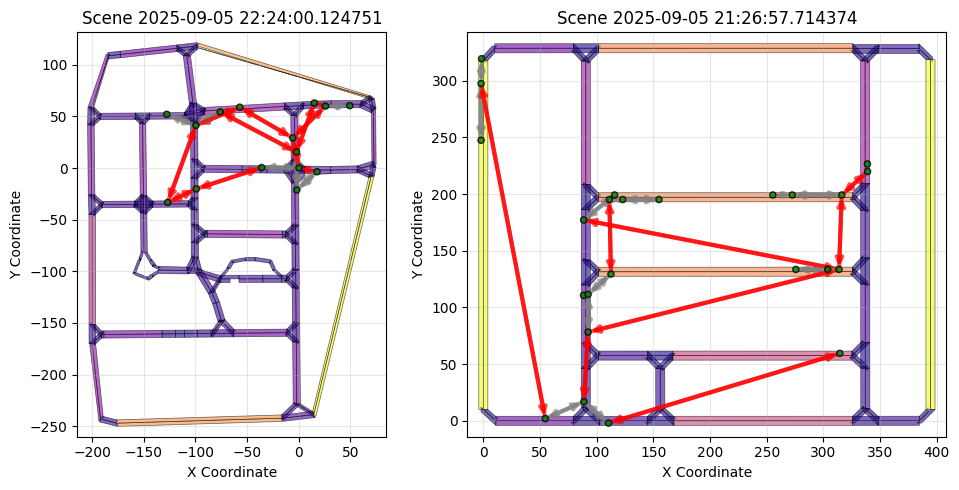

2025-09-05 22:59:21.654030_10_0 2025-09-05 22:59:21.654030
2025-09-05 21:23:45.684656_7_0 2025-09-05 21:23:45.684656


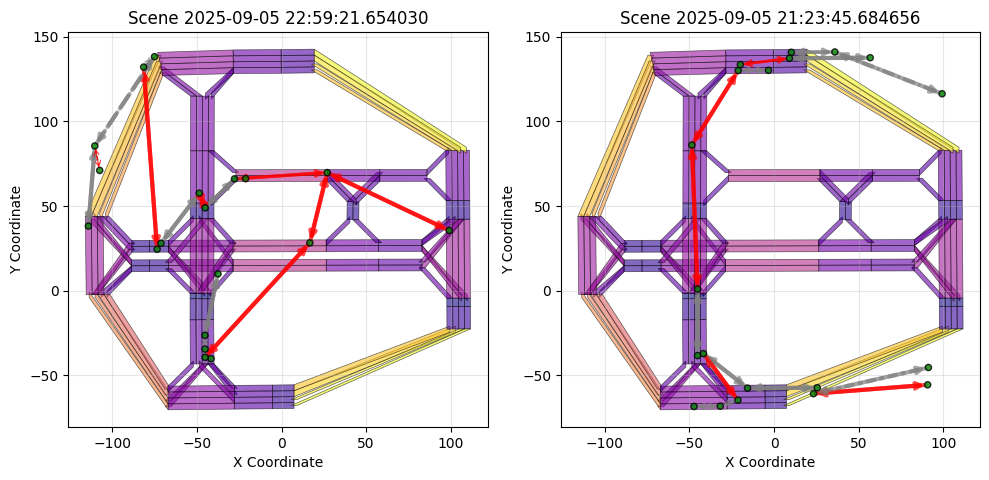

2025-09-05 22:24:23.763920_9_3 2025-09-05 22:24:23.763920
2025-09-05 23:19:00.694288_0_0 2025-09-05 23:19:00.694288


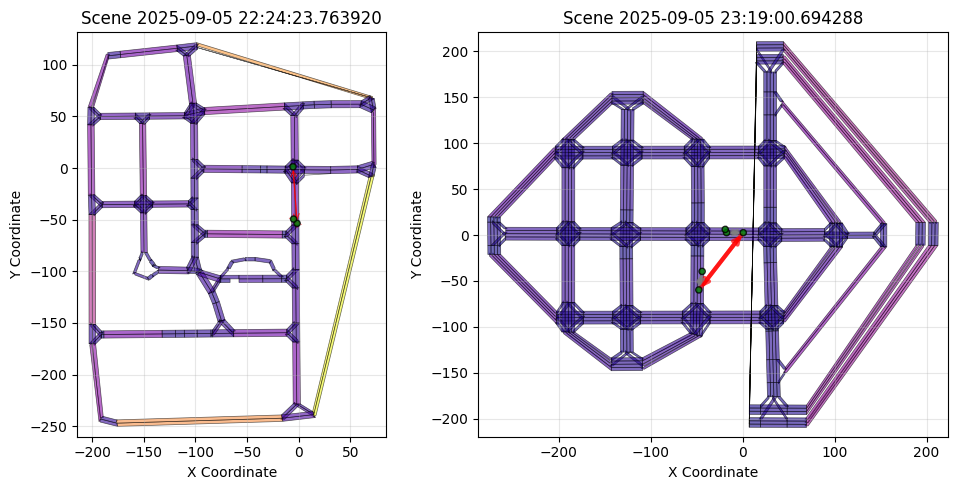

2025-09-05 21:55:40.208269_15_0 2025-09-05 21:55:40.208269
2025-09-05 21:54:43.678038_4_1 2025-09-05 21:54:43.678038


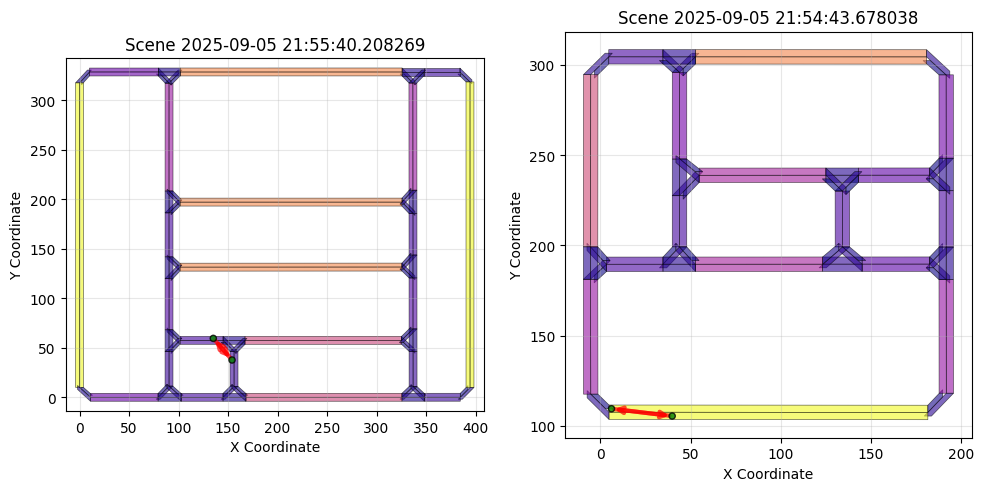

In [20]:
# comparing carla to carla
for i in range(10):
    try:
        first = pca_carla_df.sample(1)
        pca_carla_df["dist"] = (pca_carla_df.pca1 - first.pca1.iloc[0])**2 + (pca_carla_df.pca2 - first.pca2.iloc[0])**2 
        pca_carla_df.sort_values("dist", inplace=True)
        #print(pca_df.graph_path.iloc[0])
        #print(pca_df.graph_path.iloc[1])
        graph_1 = pca_carla_df.graph_path.iloc[0].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        graph_2 = pca_carla_df.graph_path.iloc[1].split("/")[-1].split(".pkl")[0].split("graph_")[1]
        scn_1 = graph_1[:26]
        scn_2 = graph_2[:26]
        print(graph_1, scn_1)
        print(graph_2, scn_2)
        pca_df.head(2)
        file_path_1 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_1}.pkl"
        with open(file_path_1, 'rb') as f:
            nx_graph_1 = pickle.load(f)
        file_path_2 = f"/home/tmuehlen/repos/graph_coverage/actor_graphs/carla/graph_{graph_2}.pkl"
        with open(file_path_2, 'rb') as f:
            nx_graph_2 = pickle.load(f)
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        # First scene (left subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_1}_map_graph.pickle')
        fig, ax1 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax1)
        fig, ax1 = add_actors_to_map(fig, ax1, nx_graph_1, actor_size=20, show_actor_labels=False)
        fig, ax1 = add_actor_edges_to_map(fig, ax1, nx_graph_1)
        ax1.set_title(f'Scene {scn_1}')
        # Second scene (right subplot)
        g_map = MapGraph()
        g_map.read_graph_from_file(f'/home/tmuehlen/repos/graph_coverage/carla/data/scene_{scn_2}_map_graph.pickle')
        fig, ax2 = plot_lane_map_advanced(g_map.graph, figsize=None, color_by_length=True, cmap='plasma', show_labels=False, fig = fig, ax = ax2)
        fig, ax2 = add_actors_to_map(fig, ax2, nx_graph_2, actor_size=20, show_actor_labels=False)
        fig, ax2 = add_actor_edges_to_map(fig, ax2, nx_graph_2)
        ax2.set_title(f'Scene {scn_2}')
        # Adjust layout and display
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing scene {scn_1} and {scn_2}: {e}")


# Notebook junkyard